# Google Drive

This first code block attaches your google drive and makes a folder structure. You only need to run this when a new VM is assigned to you. To get your code as a single python file go through the following menus File->'Download .py'.

This also downloads the 5 files that contain the dataset and the checkpoint:


https://drive.google.com/open?id=1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh

https://drive.google.com/open?id=18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv

https://drive.google.com/open?id=1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz

https://drive.google.com/open?id=1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a

https://drive.google.com/open?id=1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ

In [0]:
# torch and torchvision imports
import torch
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [4]:
import os
from google.colab import drive

# Mount google drive
DRIVE_MOUNT='/content/gdrive'
drive.mount(DRIVE_MOUNT)


# create folder to write data to
CIS680_FOLDER=os.path.join(DRIVE_MOUNT, 'My Drive', 'CIS680_2019')
HOMEWORK_FOLDER=os.path.join(CIS680_FOLDER, 'HW3a')
os.makedirs(HOMEWORK_FOLDER, exist_ok=True)

# bootstrap environment into place
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
drive_service = build('drive', 'v3')

import io
import os
from googleapiclient.http import MediaIoBaseDownload

def download_file(fn, file_id):
    request = drive_service.files().get_media(fileId=file_id)
    downloaded = io.BytesIO()
    downloader = MediaIoBaseDownload(downloaded, request)
    done = False
    while done is False:
        # _ is a placeholder for a progress object that we ignore.
        # (Our file is small, so we skip reporting progress.)
        _, done = downloader.next_chunk()
    
    downloaded.seek(0)

    folder = fn.split('/')
    if len(folder) > 1:
        os.makedirs(folder[0], exist_ok=True)

    with open(fn, 'wb') as f:
        f.write(downloaded.read())

id_to_fn = {
'1uBWazGxSZgWs70JjSWBu-KZwy5sAcxLh': 'hw3_mycocodata_bboxes_comp_zlib.npy',
'18Bh2qwVwdDwu7JK_plrnpAz9KjA5gWkv': 'hw3_mycocodata_img_comp_zlib.h5',
'1K4eZGmbW0peZvcSRpgJeCSuI6A6PWZYz': 'hw3_mycocodata_labels_comp_zlib.npy',
'1xIzQrhWrJeid1J8YLFMt8yigFVDA-N8a': 'hw3_mycocodata_mask_comp_zlib.h5',
'1fZY-tP2MuUYCA7Ur0C0zGTfEBs1XswGQ': 'checkpoint680.pth',
}

# download all files into the vm
for fid, fn in id_to_fn.items():
    print("Downloading %s from %s" % (fn, fid))
    download_file(fn, fid)

Mounted at /content/gdrive


# Load Checkpoint
Here is some sample code to load the pretrained model we are providing

In [5]:
import torchvision
import torch

def pretrained_model_680(checkpoint_file):

    import torchvision
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=False)
    
    model.eval()
    
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    model.to(device)
    
    backbone = model.backbone
    rpn = model.rpn
    
    checkpoint = torch.load(checkpoint_file)
    
    backbone.load_state_dict(checkpoint['backbone'])
    rpn.load_state_dict(checkpoint['rpn'])
    
    return backbone, rpn


backbone,rpn = pretrained_model_680('checkpoint680.pth')

# Demo of the backbones and RPN
E = torch.ones([1,3,800,1088], device='cuda')
backout = backbone(E)
print(len(backout))


from torchvision.models.detection.image_list import ImageList 
im_lis = ImageList(E, [(800,1088)])

rpn.eval()
rpnout = rpn(im_lis,backout, [{"boxes":torch.tensor([596.0027, 738.8528, 675.9938, 800.0000])}])
print(rpnout)

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth



5
([tensor([[  0.0000,   0.0000, 109.5225,  34.7064],
        [  0.0000,   0.0000, 198.6675,  69.8575],
        [  0.0000,   0.0000, 565.8074,  58.1282],
        ...,
        [596.0027, 738.8528, 675.9938, 800.0000],
        [580.0027, 738.8528, 659.9938, 800.0000],
        [564.0027, 738.8528, 643.9938, 800.0000]], device='cuda:0')], {})


# PyTorch Dataset

Copy your HW3a dataset code

In [0]:
class HW3Dataset(torch.utils.data.Dataset):
    def __init__(self, path):
        self.path = path
        ## indicate the path for different dataset
        # imgs & mask data is h5 format
        # labels & bboxes data is npy format
        imgs_path, masks_path, labels_path, bboxes_path = self.path
        # load the data coarse data
        self.imgs_data = h5py.File(imgs_path, 'r')['data'][:]
        self.labels_data = np.load(labels_path,allow_pickle=True)
        self.masks_data = np.array(h5py.File(masks_path, 'r')['data'][:],dtype=np.float)
        self.bboxes_data = np.load(bboxes_path,allow_pickle=True)
        # assign the multiple mask to each img
        index_assign = 0
        self.mask_list = []
        for i,element in enumerate(self.labels_data):
            # how many items in this image
            item_number = len(element)
            mask_pict = self.masks_data[index_assign:index_assign+item_number,]
            self.mask_list.append(mask_pict)
            # next iteration index
            index_assign += item_number
        self.mask_list = np.array(self.mask_list)
    def __getitem__(self, index):
#         batch = {'index': index}
        img = torch.tensor(self.imgs_data[index]/255, dtype = torch.float)
        label = torch.tensor(self.labels_data[index], dtype = torch.float)
        mask = torch.tensor(self.mask_list[index],dtype = torch.float)
        bbox = torch.tensor(self.bboxes_data[index], dtype = torch.float)
        return img, label, mask, bbox
    def __len__(self):
        return len(self.imgs_data)

In [0]:

# file path and make a list
imgs_path = './hw3_mycocodata_img_comp_zlib.h5'
masks_path = './hw3_mycocodata_mask_comp_zlib.h5'
labels_path = "./hw3_mycocodata_labels_comp_zlib.npy"
bboxes_path = "./hw3_mycocodata_bboxes_comp_zlib.npy"
paths = [imgs_path,masks_path,labels_path,bboxes_path]
# load the data into data.Dataset
dataset = HW3Dataset(paths)

In [0]:
# set 80% of the dataset as the training data 
full_size = len(dataset)
train_size = int(full_size * 0.8)
test_size = full_size - train_size
# random split the dataset into training and testset
# set seed
torch.random.manual_seed(1)
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])
# train_dataset = torch.utils.data.Subset(dataset, range(train_size))
# test_dataset = torch.utils.data.Subset(dataset, range(train_size,full_size))
# push the randomized training data into the dataloader
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)


# Resize the image, mask and bounding box

In [0]:
# This function take care of the pre-process of img,mask,bbox 
# in the input mini-batch
# img: 1*3*300*400
# mask: 1*3*300*400
# bbox: 1*n_box*4
def pre_process_batch(img, mask, bbox, target_h, target_w, pad):
    # get the ori size
    ori_h, ori_w = img.shape[2], img.shape[3]
    # compute the zoom ratio
    h_zoom_ratio, w_zoom_ratio = target_h/ori_h, target_w/ori_w
    # print(img.shape)
    ## rescale, normalize and padding the img
    # rescale to 800*1066, keep the ratio
    img = F.interpolate(img, size=[800,1066])
    # normalize the picture 
    img_squeeze = transforms.functional.normalize(img.squeeze(0), 
                                                  [0.485, 0.456, 0.406], 
                                                  [0.229, 0.224, 0.225], inplace=False)
    # add the batch back
    img = img_squeeze.unsqueeze(0)
    # padding to 800*1088
    img = F.pad(img, (pad, pad))

    ## rescale and pad the mask
    # rescale to 800*1066
    mask = F.interpolate(mask, size=[800,1066])
    # pad the mask
    mask = F.pad(mask, (pad, pad))
        
    ## rescale the bbox
    # print("-------------------")
    for i, box in enumerate(bbox.squeeze(0)):
        # get the modify the coor
        bbox[:,i,0] = bbox[:,i,0] * w_zoom_ratio + pad
        bbox[:,i,1] = bbox[:,i,1] * h_zoom_ratio
        bbox[:,i,2] = bbox[:,i,2] * w_zoom_ratio + pad
        bbox[:,i,3] = bbox[:,i,3] * h_zoom_ratio
    # print(bbox.shape)
    # print(bbox)
    # print("-------------------")
    return img, mask, bbox

# Plot the dataset (Demo)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cuda:0
before the preprocess, data dimensions
img shape torch.Size([1, 3, 300, 400])
label shape torch.Size([1, 1])
label tensor([[2.]], device='cuda:0')
mask shape torch.Size([1, 1, 300, 400])
bbox shape torch.Size([1, 1, 4])
start preprocess the image...
data dimensions after preprocess
img shape torch.Size([1, 3, 800, 1088])
mask shape torch.Size([1, 1, 800, 1088])
bbox shape torch.Size([1, 1, 4])
bbox coor tensor([[[466.4984, 467.9167, 567.7684, 695.2500]]], device='cuda:0')
type of bbox <class 'torch.Tensor'>
bbox tensor([[[466.4984, 467.9167, 567.7684, 695.2500]]], device='cuda:0')
bbox_dict {'boxes': tensor([[[466.4984, 467.9167, 567.7684, 695.2500]]], device='cuda:0')}
bbox_dict type <class 'dict'>
([tensor([[469.0392, 477.5468, 557.5210, 697.0945],
        [ 96.5668, 501.5818, 932.9694, 736.9928],
        [227.1252, 595.4506, 824.0913, 751.7811],
        ...,
        [418.6291, 215.5919, 576.1124, 250.4991],
        [693.3940, 547.0301, 703.9808, 557.4772],
        [672.3165, 

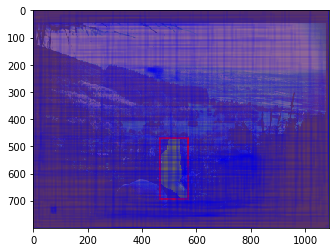

In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Assuming that we are on a CUDA machine, this should print a CUDA device:
print(device)

def plot_proposal(proposal_coor):
    x1,y1,x2,y2 = proposal_coor
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="b",facecolor='none',lw=2,alpha=0.05)
    ax.add_patch(rect)

# target h & w
target_h, target_w = 800, 1066
# pad
pad = 11
## push the img into the backbones and RPN
for i, data in enumerate(train_loader,0):
    # image pre-process
    img, label, mask, bbox = [data[i].to(device) for i in range(len(data))]
    print("before the preprocess, data dimensions")
    print('img shape',img.shape)
    print('label shape', label.shape)
    print("label", label)
    print('mask shape',mask.shape)
    print('bbox shape',bbox.shape)
    print("start preprocess the image...")
    img,mask,bbox = pre_process_batch(img,mask,bbox, target_h, target_w, pad)
    print("data dimensions after preprocess")
    print('img shape',img.shape)
    print('mask shape',mask.shape)
    print('bbox shape',bbox.shape)
    print("bbox coor", bbox)
    
    # plot the origin img
    fig, ax = plt.subplots(1)
    ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
    # plot the mask
    for i in range(mask.squeeze(0).shape[0]):
        # print("i-th mask",i)
        plt.imshow(mask.cpu().squeeze(0)[i], 'Greys', interpolation='none', alpha=0.5)
    # plot the box
    for i in range(bbox.squeeze(0).shape[0]):
        # coor of box
        x1,y1,x2,y2 = bbox.squeeze(0)[i]
        rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        ax.add_patch(rect)
    # feed the img to backbone & RPN
    backout = backbone(img)
    # prepare the data for the RPN
    im_lis = ImageList(img, [(800,1088)])

    print("type of bbox", type(bbox))
    print('bbox', bbox)
    bbox_dict = {'boxes':bbox}
    print("bbox_dict", bbox_dict)
    print("bbox_dict type", type(bbox_dict))
    rpn.eval()
    rpnout = rpn(im_lis, backout, [bbox_dict])
    print(rpnout)
    # push the rpnout into NMS first
    # print("rpnout",rpnout[0][0][0])
    # plot proposals
    ## rpnout[0][0] is the bbox tensor 
    print("RPN dimension in the rpnout",rpnout[0][0].shape)
    for proposal in rpnout[0][0]:
        # print(proposal)
        plot_proposal(proposal)
    ##plot the mask
    for mk in range(mask.squeeze(0).shape[0]):
        print(str(mk)+"-th mask shape", mask.squeeze(0)[mk,:,:].shape)
        ax.imshow(np.array(mask.squeeze(0)[mk,:,:].cpu()),alpha=0.6)
    if i == 0:
        break
# # Demo of the backbones and RPN
# E = torch.ones([1,3,800,1088], device='cuda')
# backout = backbone(E)
# print('backout lens',len(backout))

# from torchvision.models.detection.image_list import ImageList 
# im_lis = ImageList(E, [(800,1088)])

# rpn.eval()
# rpnout = rpn(im_lis,backout,[{"boxes":torch.tensor([596.0027, 738.8528, 675.9938, 800.0000])}])
# print(rpnout)
# print(len(rpnout[0][0]))

In [11]:
# Demo of the backbones and RPN
E = torch.ones([1,3,800,1088], device='cuda')
backout = backbone(E)
print('backout lens',len(backout))
print(backout.keys())
from torchvision.models.detection.image_list import ImageList 
im_lis = ImageList(E, [(800,1088)])
print("type of backout",type(backout))
print("P2 from backout shape", backout["2"].shape)
print("P1 from backout shape", backout["1"].shape)
train_featmap = {}
train_featmap["2"] = backout["2"]
print(train_featmap.keys())

rpn.eval()
rpnout = rpn(im_lis,train_featmap)
props = np.array(rpnout[0][0].cpu())
print(rpnout)
print(rpnout[0][0].shape)
print(rpnout[0][0][0,:].shape)
print(props)

backout lens 5
odict_keys(['0', '1', '2', '3', 'pool'])
type of backout <class 'collections.OrderedDict'>
P2 from backout shape torch.Size([1, 256, 50, 68])
P1 from backout shape torch.Size([1, 256, 100, 136])
dict_keys(['2'])
([tensor([[   0.0000,  767.8411,    6.8782,  800.0000],
        [1061.9812,    0.0000, 1088.0000,    3.7284],
        [1059.9321,  777.8220, 1088.0000,  791.3236],
        ...,
        [ 241.8975,  584.0415,  340.1398,  593.5680],
        [ 209.8975,  584.0415,  308.1398,  593.5680],
        [ 369.8975,  584.0415,  468.1398,  593.5680]], device='cuda:0')], {})
torch.Size([870, 4])
torch.Size([4])
[[   0.         767.84106      6.8782115  800.       ]
 [1061.9812       0.        1088.           3.72841  ]
 [1059.9321     777.822     1088.         791.3236   ]
 ...
 [ 241.89752    584.0415     340.13983    593.568    ]
 [ 209.89752    584.0415     308.13983    593.568    ]
 [ 369.89752    584.0415     468.13983    593.568    ]]


# ROI Align
ROI regularize each proposal into 7 * 7 bins.



In [54]:
## CHECKED!
# this function give the ratio split vect
def ratioSplit(bins):
    # compute the total number of splits
    n_split = (bins+1) + bins*2
    # construct the full split array
    full_split = np.linspace(0,1,n_split)
    # keep the in-bin pts
    keep_idx = (np.arange(n_split) % 3) != 0
    ratio_split = full_split[keep_idx]
    return ratio_split
# test case
ratio_split_test = ratioSplit(7)
print(ratio_split_test)

#------------------------------------------------------
## CHECKED!
## this function apply ROI Align to each proposal
# input:
    # feat_map: 1*256*50*68 (when training only P2 is used)
    # proposal coor: 4,
    # h,w: the size of the ori_image 800, 1088
    # ratio_split, (n,)
# output:
    # 1 * 256 * (2*P) * (2*P)
def roiAlign(feat_map, prop_coor, h, w, ratio_split):
    # print("----------------------------------------------------")
    # print("prop_coor",prop_coor)
    # print("feat_map shape", feat_map.shape)
    feat_map = feat_map.detach().numpy()
    prop_coor = prop_coor.detach().numpy()
    # tensorize the ratio_split
    ratio_split = torch.tensor(ratio_split)
    # squeeze the feat map, get C * feat_h * feat_w
    feat_map = feat_map.squeeze(0)
    # indicate the feature map shape
    _, feat_h, feat_w = feat_map.shape
    # print("feat_h", feat_h)
    # print("feat_w", feat_w)
    # compute the zoom ratio, ratio > 1
    ratio_h, ratio_w = h/feat_h, w/feat_w
    # print("ratio_h", ratio_h)
    # print("ratio_w", ratio_w)
    # get the coor of prop in ori image
    x1,y1,x2,y2 = prop_coor
    # compute the feat_coor and its floor&ceil
    feat_x1,feat_y1,feat_x2,feat_y2 = x1/ratio_w, y1/ratio_h, x2/ratio_w, y2/ratio_h
    f_feat_x1, f_feat_y1, f_feat_x2, f_feat_y2 =  np.floor([feat_x1,feat_y1,feat_x2,feat_y2])
    c_feat_x1, c_feat_y1, c_feat_x2, c_feat_y2 = np.ceil([feat_x1,feat_y1,feat_x2,feat_y2])
    # print("feat_y1\n", feat_y1)
    # print("feat_y2\n", feat_y2)
    # print("feat_x1\n", feat_x1)
    # print("feat_x2\n", feat_x2)
    ## generate the sampling points x,y
    x = feat_x1 + (ratio_split * (feat_x2-feat_x1))
    y = feat_y1 + (ratio_split * (feat_y2-feat_y1))
    
    # generate the meshgrid and f&c meshgrid for these coors
    xx, yy = np.meshgrid(x,y)
    # print("xx",xx)
    # print("yy",yy)
    f_xx = np.floor(xx).astype(np.int)
    f_yy = np.floor(yy).astype(np.int)
    c_xx = np.ceil(xx).astype(np.int)
    c_yy = np.ceil(yy).astype(np.int)
    # get the 4 corner block matrix in the feature map
    # print("f_yy",f_yy)
    # print("f_xx",f_xx)
    F_fxfy = feat_map[:, f_yy, f_xx]
    F_fxcy = feat_map[:, np.minimum(c_yy, feat_h - 1), f_xx]
    F_cxfy = feat_map[:, f_yy, np.minimum(c_xx, feat_w - 1)]
    F_cxcy = feat_map[:, np.minimum(c_yy, feat_h - 1), np.minimum(c_xx, feat_w - 1)]

    # compute the bi-linear for prop in feat map
    denom = 1 / ((c_xx - f_xx)*(c_yy - f_yy))
    numer = (torch.tensor(np.abs(c_xx-xx))*F_fxfy + torch.tensor(np.abs(xx-f_xx))*F_cxfy)*torch.tensor(np.abs(c_yy-yy)) + (torch.tensor(np.abs(c_xx-xx))*F_fxcy + torch.tensor(np.abs(xx-f_xx))*F_cxcy)*torch.tensor(np.abs(yy-f_yy))
    # interploting matrix results
    prop_feat_mat = numer / denom
    # reshape the prop_feat_mat, add the batch dimension
    # print(prop_feat_mat.unsqueeze(0).shape)
    # print(prop_feat_mat)
    return prop_feat_mat.unsqueeze(0)

[0.04761905 0.0952381  0.19047619 0.23809524 0.33333333 0.38095238
 0.47619048 0.52380952 0.61904762 0.66666667 0.76190476 0.80952381
 0.9047619  0.95238095]


# Model definition

In [0]:
# this network get the output from the roiAlign function
# and do the pooling
# Input:
    # roiAlign: 1 * 256 * (2*P) * (2*P)
# output:
    # roiAlignPool: 1 * 256 * P * P
class roiAlignPool(torch.nn.Module):
    def __init__(self):
        super(roiAlignPool, self).__init__()
        # ROIAlignPool receive output from roiAlign function 
        self.max_pool = nn.AvgPool2d(2,stride=2,padding=0)
    def forward(self, X):
        X = self.max_pool(X)
        return X
# this network will predict the cls and reg part of the FastRCNN
# Input:
    # roiAlignPool: 1 * 256 * P * P
# output:
    # 
class FRC(torch.nn.Module):
    def __init__(self):
        super(FRC, self).__init__()
        ### two branches splits
        ## This part is for Faster-RCNN heads
        self.linear1 = nn.Linear(256*7*7, 1024)
        self.linear2 = nn.Linear(1024,1024)

        ## from the representation vecter continue to branch out
        # cls branch for the fast_RCNN
        self.linear3 = nn.Linear(1024, 4)
        # reg branch 
        self.linear4 = nn.Linear(1024, 3*4)

        ## This part is for the mask heads
    def forward(self, X):
        ## This part is for Faster-RCNN heads
        X = X.view(-1,256*7*7)
        X = F.relu(self.linear1(X))
        X = F.relu(self.linear2(X))

        ## from the representation vecter continue to branch out
        # cls branch for the fast_RCNN
        X_cls = F.softmax(self.linear3(X))
        # reg branch for the fast_RCNN
        X_reg = self.linear4(X)
        
        return X_cls, X_reg
class Mask(torch.nn.Module):
    def __init__(self):
        super(Mask, self).__init__()
        pass
    def forward(self, X):
        pass


# Uitilize functions

Here is some useful functions for futher usage.

In [65]:
# this function will compute the IoU between one proposal and box
# input: 
    # prop_mat N*4
    # gt_mat M*4
# output:
    # IoU matrix: N*M
def IoU(prop_mat, gt_mat):
    if prop_mat.shape == (4,):
        prop_mat = prop_mat.reshape(1,-1)
    if gt_mat.shape == (4,):
        gt_mat = gt_mat.reshape(1,-1)
    
    # compute the range of the anchor box
    x_p_min = (prop_mat[:,0] - prop_mat[:,2]/2).reshape(-1,1)
    x_p_max = (prop_mat[:,0] + prop_mat[:,2]/2).reshape(-1,1)
    y_p_min = (prop_mat[:,1] - prop_mat[:,3]/2).reshape(-1,1)
    y_p_max = (prop_mat[:,1] + prop_mat[:,3]/2).reshape(-1,1)
    # compute the anchor area
    area_p = (prop_mat[:,2] * prop_mat[:,3]).reshape(-1,1)
    # print("x_p_max",x_p_max)
    # print("area_p",area_p)
    # compute the range of the gt bounding box
    x_gt_min = (gt_mat[:,0] - gt_mat[:,2]/2).reshape(-1,1)
    x_gt_max = (gt_mat[:,0] + gt_mat[:,2]/2).reshape(-1,1)
    y_gt_min = (gt_mat[:,1] - gt_mat[:,3]/2).reshape(-1,1)
    y_gt_max = (gt_mat[:,1] + gt_mat[:,3]/2).reshape(-1,1)
    # compute the gt area
    area_gt = (gt_mat[:,2] * gt_mat[:,3]).reshape(-1,1)
    # print("x_gt_max",x_gt_max)
    # print("area_gt",area_gt)
    assert x_p_max.shape[0] > 1
    # print("np.minimum(x_p_max, x_gt_max.T)\n",np.minimum(x_p_max, x_gt_max.T))
    # print("x_p_min",x_p_min)
    # print("x_gt_min",x_gt_min)
    # print("np.maximum(x_p_min, x_gt_min.T",np.maximum(x_p_min, x_gt_min.T))
    # print("np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T\n",
    #       np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T))
    # print("np.maximum(np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T), 0)\n",
    #       np.maximum(np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T), 0))
    
    # compute the intersect w & h
    intersect_p_gt_w = np.maximum(np.minimum(x_p_max, x_gt_max.T) - np.maximum(x_p_min, x_gt_min.T), 0)
    
    intersect_p_gt_h = np.maximum(np.minimum(y_p_max, y_gt_max.T) - np.maximum(y_p_min, y_gt_min.T), 0)
    # compute intersect area
    area_intersect = intersect_p_gt_w * intersect_p_gt_h
    # print("area_intersect",area_intersect)
    # compute union area
    area_union = (area_p + area_gt.T) - area_intersect
    # print("area_union",area_union)
    # print(area_intersect)
    # print(area_union)
    IoU = area_intersect / area_union
    # print("IoU",IoU)
    # print("----------------------------")
    return IoU
# this function change the x1y1x2y2 system to xywh system
def xyxyToxywh(coor):
    return (coor[0]+coor[2])/2, (coor[1]+coor[3])/2, coor[2]-coor[0], coor[3]-coor[1]

def refineCompute(prop_x, prop_y, prop_w, prop_h, gt_x, gt_y, gt_w, gt_h):
    t_x = (gt_x - prop_x) / prop_w
    t_y = (gt_y - prop_y) / prop_h
    t_w = np.log(gt_w / prop_w)
    t_h = np.log(gt_h / prop_h)
    return t_x, t_y, t_w, t_h

# this function will pre-process the proposals
# i.e. will subsample the proposal for the training use
def propSubSample(sample_num, p_n_list, seed=0):
    print("subsampling...")
    sample_num = torch.tensor(sample_num)
    # set the seed for the random sampling
    np.random.seed(seed)

    # idx the T/F list
    idx = torch.arange(len(p_n_list))
    
    # pos number & neg number
    pos_num = torch.min(torch.sum(p_n_list), sample_num/4)
    neg_num = pos_num * 3
    print("Exist pos num", pos_num)
    print("Exist neg num", neg_num)
    
    # print("idx shape", idx.shape)
    # pos_idx & neg_idx
    pos_idx = idx[p_n_list]
    neg_idx = idx[~p_n_list]

    # print("pos idx", pos_idx)
    # print("neg idx", neg_idx)
    # print(torch.sum(p_n_list))
    # print(sample_num/4)
    # subsampling
    pos_sub = np.random.choice(pos_idx, np.array(pos_num), replace=False)
    neg_sub = np.random.choice(neg_idx, np.array(neg_num), replace=False)
    sub_sampling = np.concatenate((pos_sub,neg_sub))
    # print(np.sort(sub_sampling))
    print("Total subsampling proposals:", len(sub_sampling))
    
    return np.sort(sub_sampling)

# test for IoU
print("test for IoU---------------------")
prop_mat = torch.tensor([[0,0,4,4],
                        [0,0,4,4]],dtype = torch.float)
gt_mat = torch.tensor([0,0,4,4],dtype = torch.float)
IoU_matrix = IoU(prop_mat,gt_mat)

print(IoU_matrix)

val, idx = torch.max(IoU_matrix, axis=1)
print("val", val)
print("idx", idx)
# prop_max_idx = torch.argmax(IoU_matrix, axis=1)


# print(prop_max_IoU)
# print("prop_max_idx",prop_max_idx)
# print("prop_max_IoU",IoU_matrix[prop_max_idx])
# print(prop_max_IoU>0.2)
print(prop_mat[val > 0.2])
# print(len(prop_max_IoU))
print("---------------------------------")

test for IoU---------------------
tensor([[1.],
        [1.]])
val tensor([1., 1.])
idx tensor([0, 0])
tensor([[0., 0., 4., 4.],
        [0., 0., 4., 4.]])
---------------------------------


In [0]:
## this function decode the fastRCNN prediction
def FRCDecoder(props, pred_matrix)

# Train the model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


cuda:0
train feat map dict val torch.Size([1, 256, 50, 68])
torch.Size([1000, 4])
bbox shape torch.Size([1, 1, 4])
bbox squeeze shape torch.Size([1, 4])
bbox squeeze tensor([247.8983, 108.1688, 845.3980, 755.7131], device='cuda:0')
(1000, 4)
------------------------------
IoU_matrix shape torch.Size([1000, 1])
idx shape torch.Size([1000])
negtive number tensor(962)
subsampling...
Exist pos num tensor(32)
Exist neg num tensor(96)
Total subsampling proposals: 128
total label shape torch.Size([1000, 1])
total proposal shape torch.Size([1000, 4])
total label shape torch.Size([128, 1])
total proposal shape torch.Size([128, 4])
tensor([399.7154, 113.5284, 828.3975, 800.0000], device='cuda:0')


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


torch.Size([128, 4])
torch.Size([128, 12])


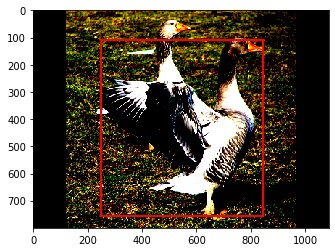

In [78]:
# Training
# Assuming that we are on a CUDA machine, this should print a CUDA device:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# target h & w
target_h, target_w = 800, 1066
# pad
pad = 11
# bg/fg threshold
bf_thresh = 0.5
# subsampling number
sample_num = 128
# roiAlign bins for FRC
bins_FRC = 7
# roiAlign bins for Mask
bins_Mask = 14
# the preprocessed img size
h, w = 800, 1088

## net information
# net initialization
roi_net = roiAlignPool()
roi_net = roi_net.float()
FRC_net = FRC()
FRC_net = FRC_net.float()
Mask_net = Mask()
Mask_net = Mask_net.float()
# optimizer = optim.Adam(FRC_net.parameters(), lr=0.001) # for test


# optimizer
paras = list(roi_net.parameters()) + list(FRC_net.parameters())
# para_dict = {}
# para_dict["roi_para"] = roi_net.parameters()
# para_dict["FRC_para"] = FRC_net.parameters()
# para_dict["Mask_para"] = Mask_net.parameters()
optimizer = optim.Adam(paras, lr=0.001)


## push the img into the backbones and RPN
for i, data in enumerate(train_loader,0):
    # Read the dataloader
    img, label, mask, bbox = [data[i].to(device) for i in range(len(data))]
    # image pre-process
    img, mask, bbox = pre_process_batch(img,mask,bbox, target_h, target_w, pad)
    
    # plot the origin img
    fig, ax = plt.subplots(1)
    ax.imshow(np.array(img.cpu().squeeze(0)).transpose(1,2,0))
    # plot the box
    for i in range(bbox.squeeze(0).shape[0]):
        # coor of box
        x1,y1,x2,y2 = bbox.squeeze(0)[i]
        rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,linewidth=1,edgecolor="r",facecolor='none',lw=2)
        ax.add_patch(rect)

    
    # push the data into backbone
    backout = backbone(img)
    im_lis = ImageList(img, [(800,1088)])
    # only use the P2 from the feature map in the training
    train_featmap = {}
    train_featmap["2"] = backout["2"]
    print("train feat map dict val", train_featmap["2"].shape)
    # push the feature map into the RPN model and get rpn as proposals
    # here I use all the FPN as the feature map in order to give the best proposal
    # if only give the P2, some close object will not be proposed
    # rpnout: 
    rpn.eval()
    rpnout = rpn(im_lis, backout)
    props = rpnout[0][0]
    print(props.shape)
    
    print("bbox shape", bbox.shape)
    print("bbox squeeze shape", bbox.squeeze(0).shape)
    print("bbox squeeze", bbox.squeeze(0)[0])
    # print(props.cpu().dtype)
    # print(bbox.squeeze(0).cpu().dtype)
    print(np.array(props.cpu()).shape)
    # bbox_sqz = 
    # IoU_matrix = IoU(np.array(props.cpu()),np.array(bbox.squeeze(0).cpu()))
    # print(IoU_matrix)

    print("------------------------------")
    assert props.cpu().dtype == torch.float
    assert bbox.squeeze(0).cpu().dtype == torch.float
    IoU_matrix = IoU(props.cpu(),bbox.squeeze(0).cpu())
    print("IoU_matrix shape", IoU_matrix.shape)
    # compute the max val and its idx for each row
    val, idx = torch.max(IoU_matrix, axis=1)
    print("idx shape", idx.shape)
    #coarse label each prop
    prop_labels = label.T[idx]

    # filter out the background, set the label for the bg as 0.
    bg_filter = val < bf_thresh
    prop_labels[bg_filter] = 0

    print("negtive number", torch.sum(bg_filter))
    train_props_idx = propSubSample(sample_num, ~bg_filter)

    print("total label shape",prop_labels.shape)
    print("total proposal shape", props.shape)


    subsample_props = props[train_props_idx]
    subsample_labels = prop_labels[train_props_idx]
    subsample_idx = idx[train_props_idx]
    print("total label shape",subsample_labels.shape)
    print("total proposal shape", subsample_props.shape)
    print(subsample_props[0])

    
    ### assemble the data for the training
    #-----------------------------------------------------------------
    # remember idx keeps the info: which proposal link to which gt box
    n_FRC_train = subsample_props.shape[0]
    ## construct Input to FastRCNN
    inputs_FRC = torch.zeros((n_FRC_train, 256, bins_FRC*2, bins_FRC*2))
    # compute ratio_split_FRC
    ratio_split_FRC = ratioSplit(bins_FRC)
    for i, prop in enumerate(subsample_props):
        inputs_FRC[i,:,:,:] = roiAlign(train_featmap["2"].cpu(), prop.cpu(), 800, 1088, ratio_split_FRC)

    assert inputs_FRC.shape == (n_FRC_train, 256, bins_FRC*2, bins_FRC*2)
    ## and gt matrix for FRC training
    ## FRC_gt: [n_FRC_train * 16]. 16=4(cls)+3(#cls num)*4()
    FRC_gt = torch.zeros((n_FRC_train, 16))
    for i in range(n_FRC_train):
        # fill in the cls info
        # print("subsample_labels[i]",np.array(subsample_labels[i].cpu(),dtype=np.int))
        FRC_gt[i, np.array(subsample_labels[i].cpu(),dtype=np.int)] = 1
        # fill in the refinement info
        link_box = idx[i]
        prop_x, prop_y, prop_w, prop_h = xyxyToxywh(subsample_props[i].cpu())
        gt_x, gt_y, gt_w, gt_h = xyxyToxywh(bbox.squeeze(0)[link_box].cpu())
        t_x, t_y, t_w, t_h = refineCompute(prop_x, prop_y, prop_w, prop_h, gt_x, gt_y, gt_w, gt_h)
        start_fill = np.array((4 + (subsample_labels[i].cpu()-1) * 4), dtype=np.int)
        # print("t_x, t_y, t_w, t_h",t_x, t_y, t_w, t_h)
        FRC_gt[i, start_fill] = t_x
        FRC_gt[i, start_fill+1] = t_y
        FRC_gt[i, start_fill+2] = t_w
        FRC_gt[i, start_fill+3] = t_h


    ### forward in the FRC
    #----------------------------------------------------------------
    ## First pass a ROIAlign
    output_roiAlign = roi_net(inputs_FRC)
    assert output_roiAlign.shape == (n_FRC_train, 256, 7, 7)
    output_FRC_cls, output_FRC_reg = FRC_net(output_roiAlign)
    print(output_FRC_cls.shape)
    print(output_FRC_reg.shape)
    
    


    # print(bg_filter)

    # print(prop_coar_label[:10])
    # print("max_val",val[:10])
    # print("max_val_filter",(val>0.3)[:10])
    # print("max_idx",idx[:10])
    # print("idx shape", idx.shape)
    # print("label",label)
    # print("label shape", label.shape)
    # print(label[idx])
    break
    # prop_mat = torch.tensor([[0,0,4,4],
    #                           [0,0,4,4]])
    # gt_mat = np.array([[2,2,4,4],
    #                 [2,0,4,4]])
    # IoU_matrix = IoU(prop_mat,gt_mat)

    # print(IoU_matrix)

    # val, idx = torch.max(IoU_matrix, axis=1)
    # print("val", val)
    # print("idx", idx)


# Test your network

Did you remember to cut out a test set? If not you really should, test on images your network has never seen.

In [0]:
label = torch.tensor([[3,2]]).T
print("label shape\n",label.shape)
# print()
idx = torch.tensor([0,0,1,0,0])
# print(idx.shape)
c_label = label[idx]
print(c_label)
temp_filter = torch.tensor([True,True,False,True,False])
print("len of filter",len(temp_filter))
print("p_n_list", temp_filter)
print("n_p_list", ~temp_filter)
c_label[temp_filter] = 0
print(c_label)

label shape
 torch.Size([2, 1])
tensor([[3],
        [3],
        [2],
        [3],
        [3]])
len of filter 5
p_n_list tensor([ True,  True, False,  True, False])
n_p_list tensor([False, False,  True, False,  True])
tensor([[0],
        [0],
        [2],
        [0],
        [3]])


In [0]:
temp = tensor([  0,   2,   3,   4,   5,   7,  11,  12,  15,  20,  21,  25,  32,  34,
         38,  39,  43,  44,  48,  49,  51,  56,  63,  73,  75,  97,  99, 121,
        125, 126, 164, 182, 184, 185, 189, 194, 214, 230, 250, 270, 276, 280,
        306, 314, 328, 392, 447, 521])
print(np.random())

In [51]:
(333+0.9524*(1088-333))/16

65.753875